# Advanced Job Market & NLP Skill Analysis 

## Overview
This notebook analyzes the processed job market data with NLP-extracted skills and provides comprehensive insights.

### Data Pipeline
1. **Raw Data**: Scraped from Naukri.com 
2. **Cleaned Data**: Validated and standardized 
3. **NLP Processing**: Skill extraction with spaCy & transformers
4. **Database Storage**: Structured in DuckDB with analytics

### Key Analyses
- Skill demand trends and market insights
- Geographic job market analysis
- Company hiring patterns
- Salary vs. skills correlation
- Emerging vs. declining skills

In [1]:
! pip install plotly matplotlib seaborn 


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the latest processed data
data_dir = Path("../data/processed")
nlp_files = list(data_dir.glob("jobs_with_nlp_*.csv"))
latest_nlp_file = max(nlp_files, key=lambda x: x.stat().st_mtime)


In [4]:
print(f" Loading NLP processed data: {latest_nlp_file.name}")
df = pd.read_csv(latest_nlp_file)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head(2)

 Loading NLP processed data: jobs_with_nlp_20250922_204813.csv
Dataset shape: (416, 24)
Columns: ['job_id', 'title', 'company', 'location', 'experience_min', 'experience_max', 'salary', 'description', 'skills_extracted', 'job_url', 'company_rating', 'posted_date', 'scraped_at', 'search_keyword', 'page_number', 'job_category', 'seniority_level', 'remote_friendly', 'skills_nlp_extracted', 'skills_all', 'skills_categorized', 'job_requirements', 'total_skills_count', 'nlp_processed_at']


,job_id,title,company,location,experience_min,experience_max,salary,description,skills_extracted,job_url,...,page_number,job_category,seniority_level,remote_friendly,skills_nlp_extracted,skills_all,skills_categorized,job_requirements,total_skills_count,nlp_processed_at
0,20925030402,Data Scientist / Machine Learning Engineer,KPMG Assurance and Consulting Services LLP,Bengaluru,4.0,9.0,NaN,Use Cloud Tools (Nice to Have): Experience wit...,"['data science', 'machine learning engineer', ...",https://www.naukri.com/job-listings-data-scien...,...,1,data_science,mid,False,"['machine learning', 'google cloud platform', ...","['statistics', 'google cloud platform', 'stati...","{""programming_languages"": [""statistics"", ""goog...","{""required_skills"": [], ""preferred_skills"": []...",10,2025-09-22T20:47:44.730509
1,170925933956,Data Scientist-Artificial Intelligence,IBM,Bengaluru,3.0,7.0,NaN,Bachelors Degree . Masters Degree . Required e...,"['natural language processing', 'neural networ...",https://www.naukri.com/job-listings-data-scien...,...,1,data_science,mid,False,['artificial intelligence'],"['predictive', 'keras', 'pandas', 'pytorch', '...","{""programming_languages"": [""predictive"", ""kera...","{""required_skills"": [], ""preferred_skills"": []...",9,2025-09-22T20:47:44.802995


In [5]:
# Load skill insights
insight_files = list(data_dir.glob("skill_insights_*.json"))
latest_insight_file = max(insight_files, key=lambda x: x.stat().st_mtime)

with open(latest_insight_file, 'r') as f:
    insights = json.load(f)

print(" Skill Market Insights Loaded:")
print(f"  Total jobs analyzed: {insights['total_jobs_analyzed']}")
print(f"  Unique skills found: {len(insights['unique_skills'])}")
print(f"  Trending skills: {len(insights['trending_skills'])}")
print(f"  Skills by location: {len(insights['skills_by_location'])} cities")

 Skill Market Insights Loaded:
  Total jobs analyzed: 416
  Unique skills found: 1020
  Trending skills: 34
  Skills by location: 31 cities


In [6]:
! pip install --upgrade nbformat


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [7]:
# Top Skills Visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Top 15 Most Demanded Skills', 'Skills by Category', 
                   'Trending vs Rare Skills', 'Skills Distribution'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "scatter"}, {"type": "histogram"}]]
)

# Top 15 skills
top_skills = list(insights['skill_frequency'].items())[:15]
skills, counts = zip(*top_skills)
fig.add_trace(
    go.Bar(x=counts, y=skills, orientation='h', name="Skill Demand"),
    row=1, col=1
)

# Skills by category
category_totals = {}
for category, skills_dict in insights['skills_by_category'].items():
    category_totals[category] = sum(skills_dict.values())

categories = list(category_totals.keys())
cat_counts = list(category_totals.values())
fig.add_trace(
    go.Bar(x=categories, y=cat_counts, name="Category Totals"),
    row=1, col=2
)

# Trending vs Rare (scatter plot)
all_skill_items = list(insights['skill_frequency'].items())
trending_skills = set(insights['trending_skills'])
rare_skills = set(insights['rare_skills'])

colors = []
for skill, count in all_skill_items:
    if skill in trending_skills:
        colors.append('red')
    elif skill in rare_skills:
        colors.append('blue')
    else:
        colors.append('gray')

skill_names, skill_counts = zip(*all_skill_items)
fig.add_trace(
    go.Scatter(
        x=list(range(len(skill_counts))), 
        y=skill_counts,
        mode='markers',
        marker=dict(color=colors, size=8),
        text=skill_names,
        name="Skills (Red=Trending, Blue=Rare)"
    ),
    row=2, col=1
)

# Skills distribution histogram
fig.add_trace(
    go.Histogram(x=skill_counts, nbinsx=20, name="Skill Count Distribution"),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Job Market Skill Analysis Dashboard")
fig.show()

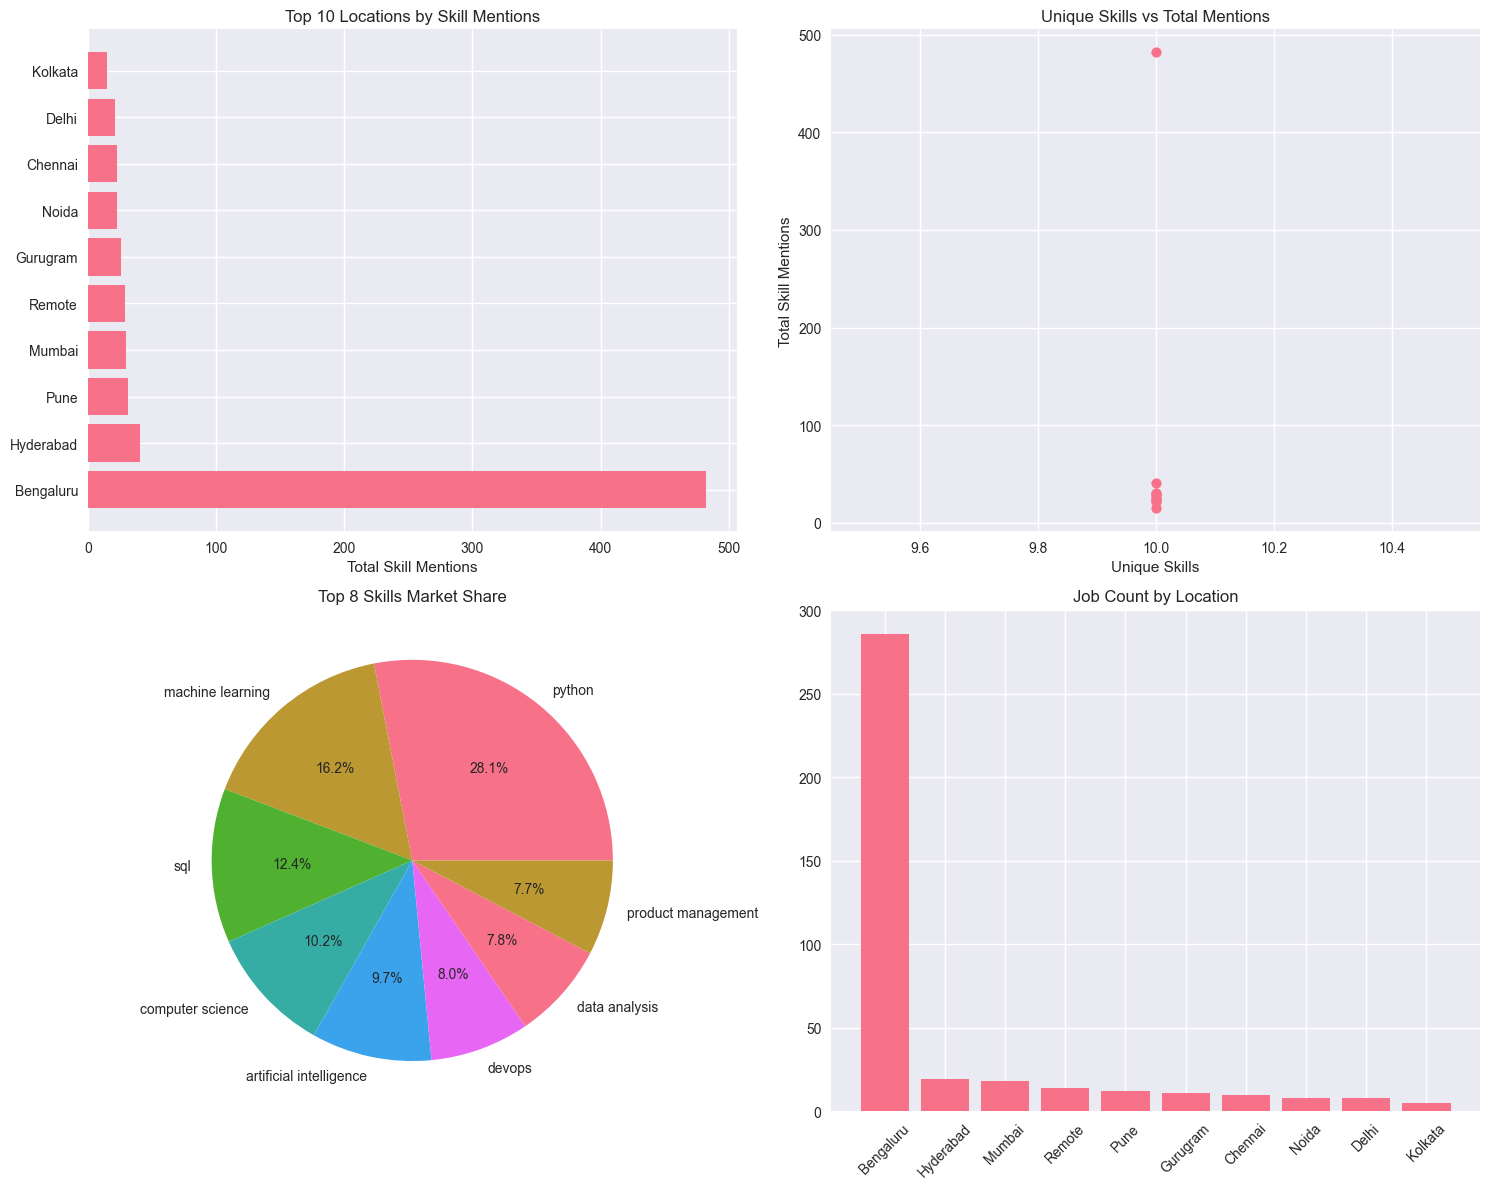

 Geographic Insights:
Top 5 job markets: Bengaluru, Hyderabad, Pune, Mumbai, Remote
Most skill-diverse location: Bengaluru


In [8]:
# Geographic Analysis
location_skills = insights['skills_by_location']

# Create a comprehensive location analysis
location_analysis = []
for location, skills_dict in location_skills.items():
    total_skills = sum(skills_dict.values())
    top_skill = max(skills_dict.items(), key=lambda x: x[1])
    
    location_analysis.append({
        'location': location,
        'total_skill_mentions': total_skills,
        'unique_skills': len(skills_dict),
        'top_skill': top_skill[0],
        'top_skill_count': top_skill[1],
        'avg_skills_per_mention': total_skills / len(skills_dict) if skills_dict else 0
    })

location_df = pd.DataFrame(location_analysis)
location_df = location_df.sort_values('total_skill_mentions', ascending=False)

# Top 10 locations visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Total skill mentions by location
top_10_locations = location_df.head(10)
axes[0,0].barh(top_10_locations['location'], top_10_locations['total_skill_mentions'])
axes[0,0].set_title('Top 10 Locations by Skill Mentions')
axes[0,0].set_xlabel('Total Skill Mentions')

# Unique skills by location
axes[0,1].scatter(top_10_locations['unique_skills'], top_10_locations['total_skill_mentions'])
axes[0,1].set_title('Unique Skills vs Total Mentions')
axes[0,1].set_xlabel('Unique Skills')
axes[0,1].set_ylabel('Total Skill Mentions')

# Top skills distribution
top_skills_data = list(insights['skill_frequency'].items())[:20]
skills_names, skills_counts = zip(*top_skills_data)
axes[1,0].pie(skills_counts[:8], labels=skills_names[:8], autopct='%1.1f%%')
axes[1,0].set_title('Top 8 Skills Market Share')

# Job count analysis (if available in df)
if 'location' in df.columns:
    location_job_counts = df['location'].value_counts().head(10)
    axes[1,1].bar(range(len(location_job_counts)), location_job_counts.values)
    axes[1,1].set_xticks(range(len(location_job_counts)))
    axes[1,1].set_xticklabels(location_job_counts.index, rotation=45)
    axes[1,1].set_title('Job Count by Location')

plt.tight_layout()
plt.show()

print(" Geographic Insights:")
print(f"Top 5 job markets: {', '.join(top_10_locations['location'].head().tolist())}")
print(f"Most skill-diverse location: {location_df.loc[location_df['unique_skills'].idxmax(), 'location']}")

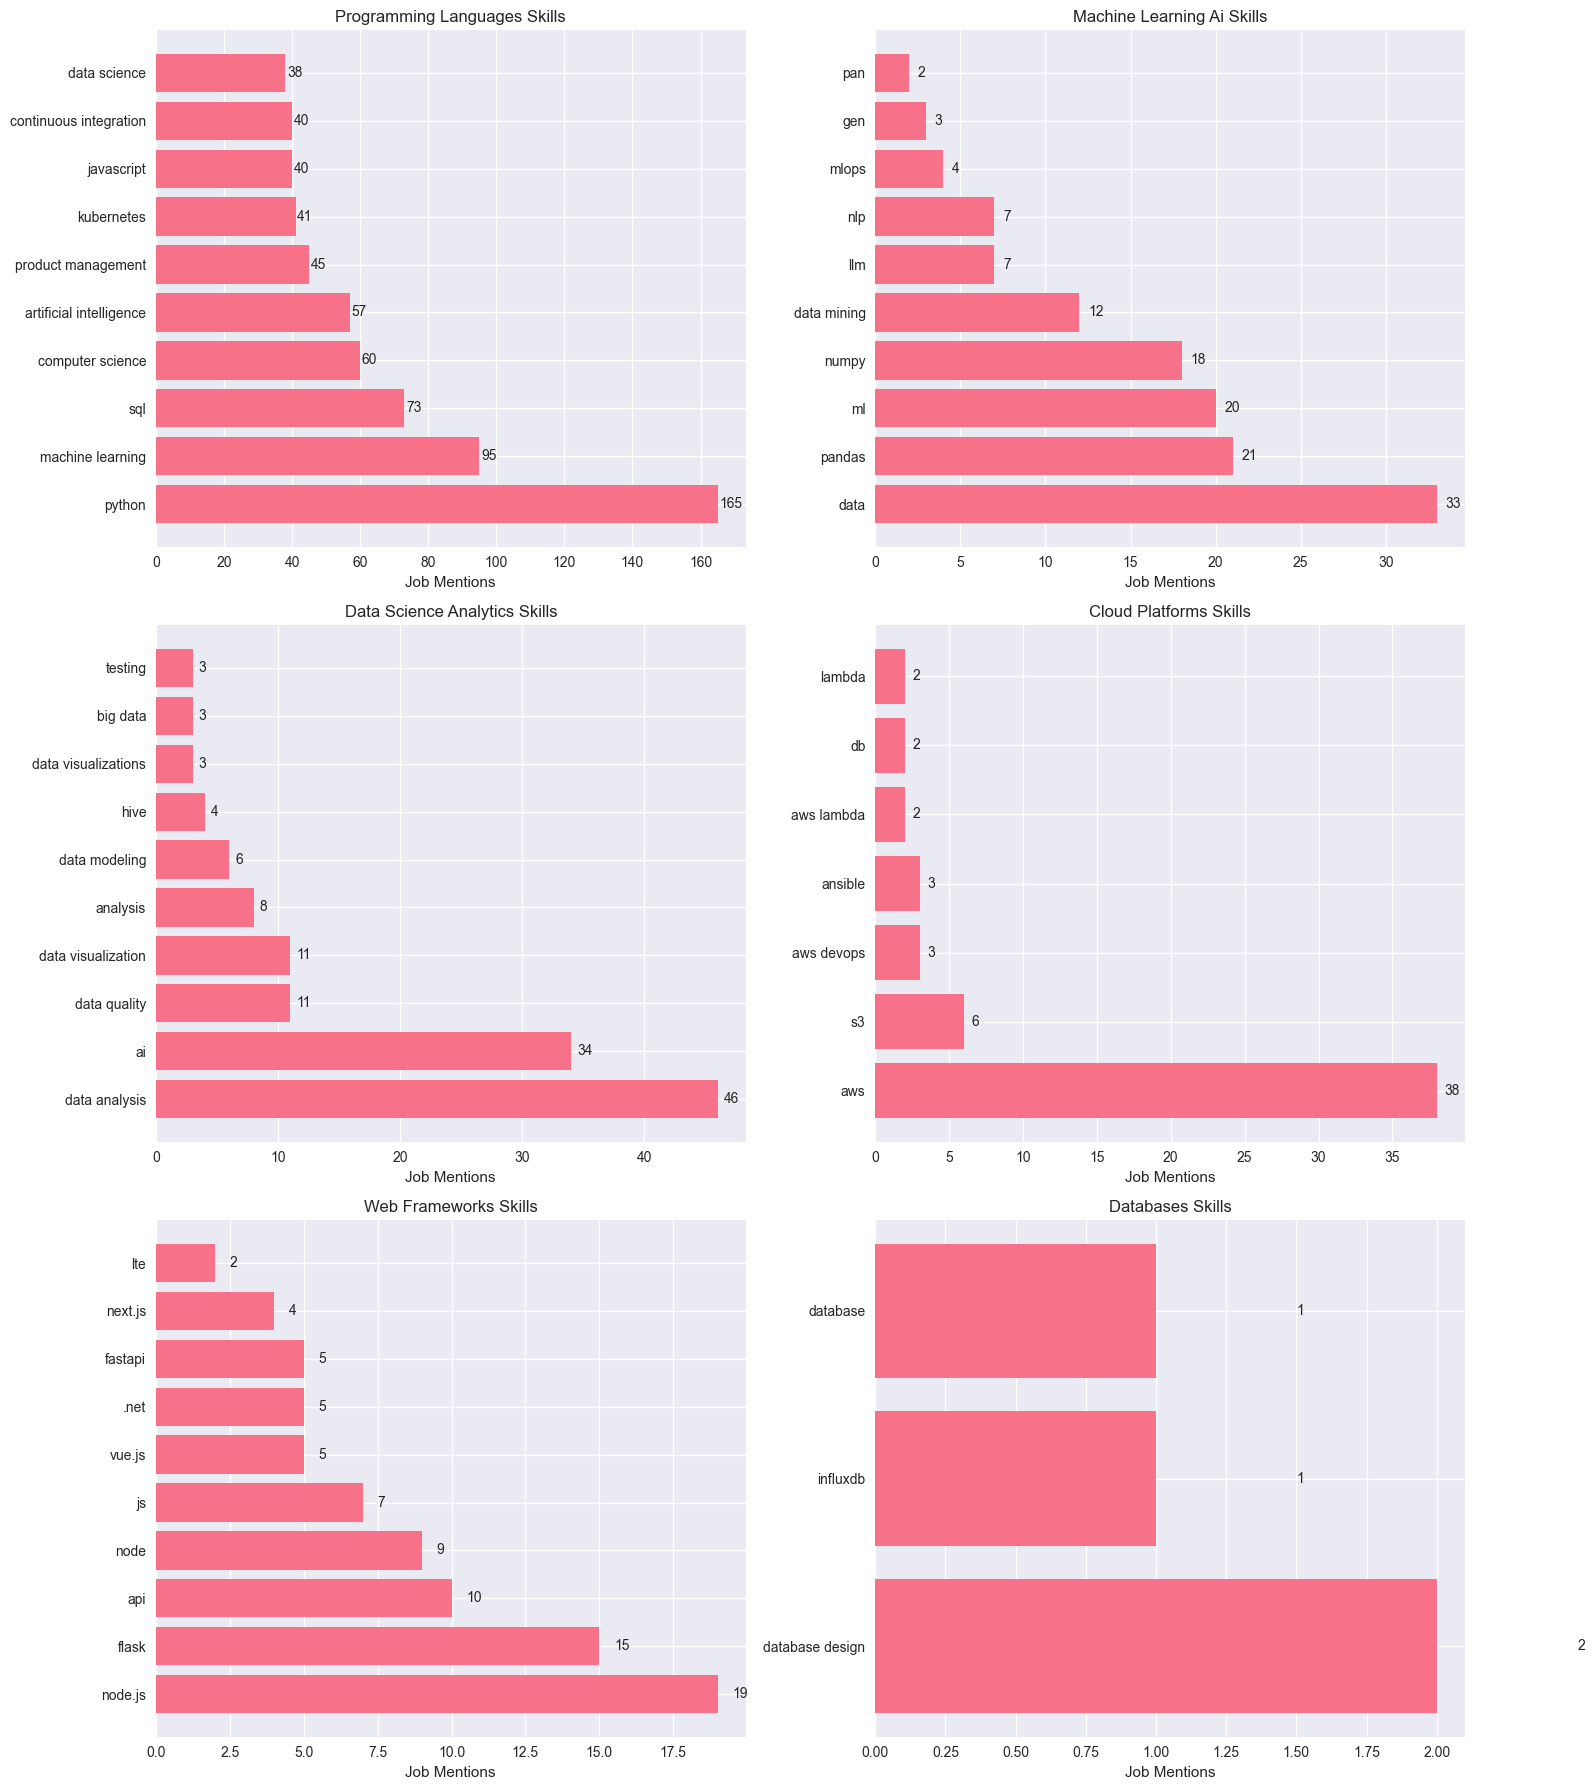

 Skills Category Analysis:

Programming Languages:
  Total mentions: 814
  Unique skills: 15
  Avg demand per skill: 54.3
  Top 3 skills: python, machine learning, sql

Machine Learning Ai:
  Total mentions: 132
  Unique skills: 15
  Avg demand per skill: 8.8
  Top 3 skills: data, pandas, ml

Data Science Analytics:
  Total mentions: 141
  Unique skills: 15
  Avg demand per skill: 9.4
  Top 3 skills: data analysis, ai, data quality

Cloud Platforms:
  Total mentions: 56
  Unique skills: 7
  Avg demand per skill: 8.0
  Top 3 skills: aws, s3, aws devops

Web Frameworks:
  Total mentions: 85
  Unique skills: 13
  Avg demand per skill: 6.5
  Top 3 skills: node.js, flask, api

Databases:
  Total mentions: 4
  Unique skills: 3
  Avg demand per skill: 1.3
  Top 3 skills: database design, influxdb, database

Devops Tools:
  Total mentions: 146
  Unique skills: 15
  Avg demand per skill: 9.7
  Top 3 skills: devops, automation, git

Soft Skills:
  Total mentions: 39
  Unique skills: 8
  Avg dema

In [9]:
# Skills Category Deep Dive
categories_data = insights['skills_by_category']

# Create detailed category analysis
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, (category, skills_dict) in enumerate(categories_data.items()):
    if idx >= 6:  # Limit to 6 categories for visualization
        break
    
    # Top 10 skills in this category
    sorted_skills = sorted(skills_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    skills_names, skills_counts = zip(*sorted_skills)
    
    axes[idx].barh(skills_names, skills_counts)
    axes[idx].set_title(f'{category.replace("_", " ").title()} Skills')
    axes[idx].set_xlabel('Job Mentions')
    
    # Add value labels on bars
    for i, v in enumerate(skills_counts):
        axes[idx].text(v + 0.5, i, str(v), va='center')

plt.tight_layout()
plt.show()

# Print category insights
print(" Skills Category Analysis:")
for category, skills_dict in categories_data.items():
    total_mentions = sum(skills_dict.values())
    unique_skills = len(skills_dict)
    avg_demand = total_mentions / unique_skills if unique_skills > 0 else 0
    
    print(f"\n{category.replace('_', ' ').title()}:")
    print(f"  Total mentions: {total_mentions}")
    print(f"  Unique skills: {unique_skills}")
    print(f"  Avg demand per skill: {avg_demand:.1f}")
    print(f"  Top 3 skills: {', '.join([skill for skill, _ in sorted(skills_dict.items(), key=lambda x: x[1], reverse=True)[:3]])}")

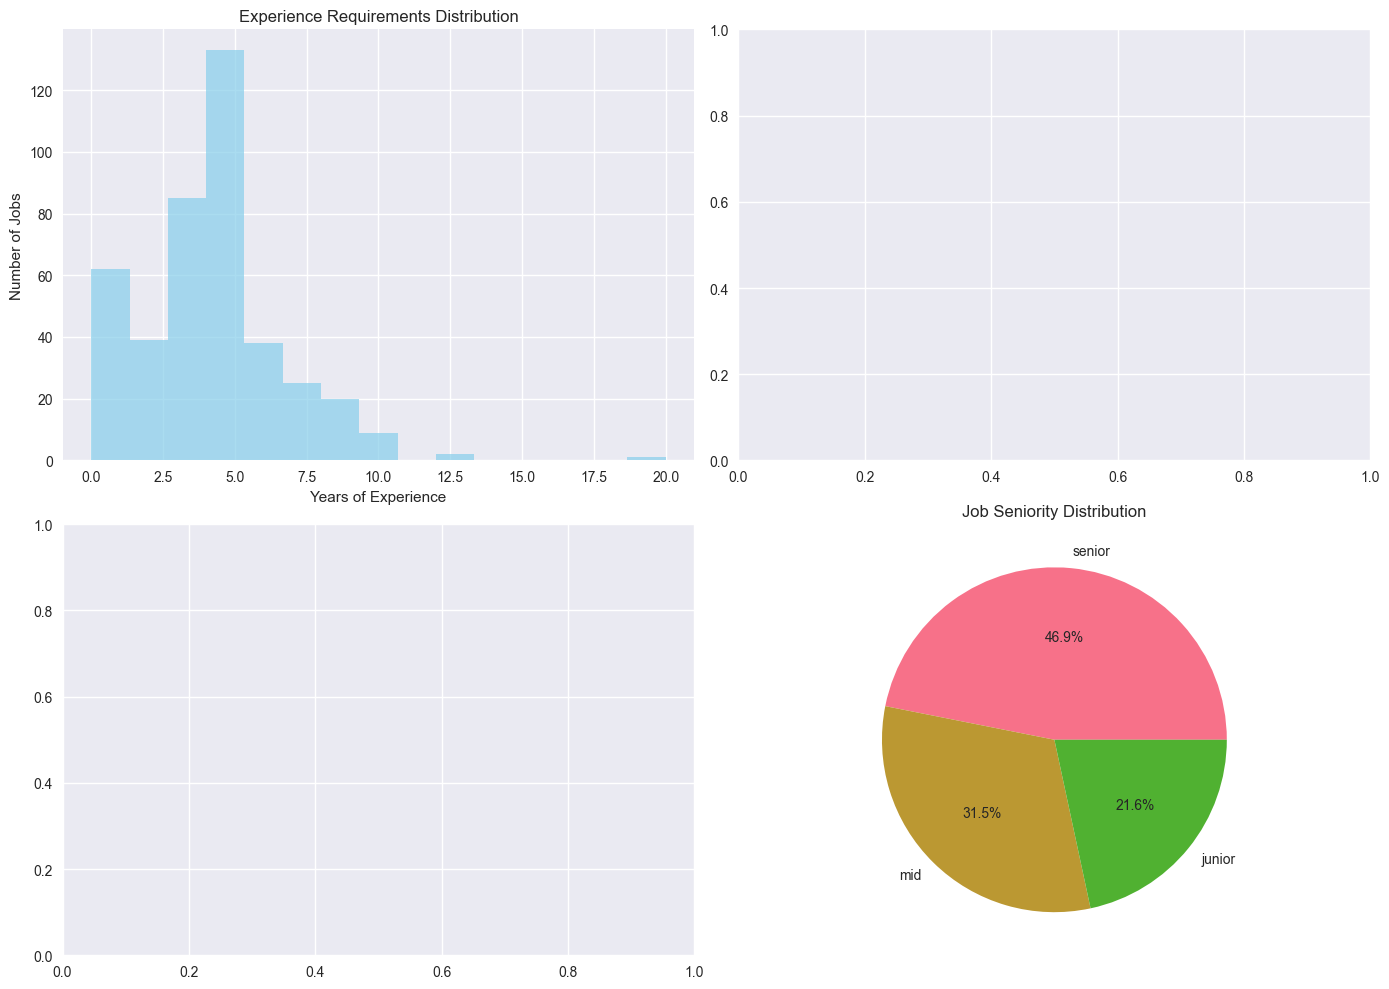

 Salary & Experience Insights:
Average experience required: 4.0 years
Most common experience range: 0.0-20.0 years


In [10]:
# Experience and Salary Analysis
experience_data = []
salary_data = []

for idx, row in df.iterrows():
    # Parse experience
    if pd.notna(row.get('experience_min')):
        experience_data.append(row['experience_min'])
    
    # Parse salary
    if pd.notna(row.get('salary_min')):
        salary_data.append(row['salary_min'])

# Create experience and salary visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Experience distribution
if experience_data:
    axes[0,0].hist(experience_data, bins=15, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Experience Requirements Distribution')
    axes[0,0].set_xlabel('Years of Experience')
    axes[0,0].set_ylabel('Number of Jobs')

# Salary distribution
if salary_data:
    axes[0,1].hist(salary_data, bins=20, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Salary Distribution (in Lakhs)')
    axes[0,1].set_xlabel('Salary (Lakhs)')
    axes[0,1].set_ylabel('Number of Jobs')

# Experience vs Salary correlation (if both available)
if experience_data and salary_data and len(experience_data) == len(salary_data):
    exp_sal_df = pd.DataFrame({
        'experience': experience_data[:min(len(experience_data), len(salary_data))],
        'salary': salary_data[:min(len(experience_data), len(salary_data))]
    })
    axes[1,0].scatter(exp_sal_df['experience'], exp_sal_df['salary'], alpha=0.6)
    axes[1,0].set_title('Experience vs Salary Correlation')
    axes[1,0].set_xlabel('Years of Experience')
    axes[1,0].set_ylabel('Salary (Lakhs)')

# Seniority level distribution
if 'seniority_level' in df.columns:
    seniority_counts = df['seniority_level'].value_counts()
    axes[1,1].pie(seniority_counts.values, labels=seniority_counts.index, autopct='%1.1f%%')
    axes[1,1].set_title('Job Seniority Distribution')

plt.tight_layout()
plt.show()

print(" Salary & Experience Insights:")
if salary_data:
    print(f"Average salary: ₹{np.mean(salary_data):.1f} Lakhs")
    print(f"Median salary: ₹{np.median(salary_data):.1f} Lakhs")
    print(f"Salary range: ₹{min(salary_data):.1f} - ₹{max(salary_data):.1f} Lakhs")

if experience_data:
    print(f"Average experience required: {np.mean(experience_data):.1f} years")
    print(f"Most common experience range: {min(experience_data)}-{max(experience_data)} years")

In [11]:
# Market Trends and Insights Summary
print(" JOB MARKET INSIGHTS SUMMARY")
print("=" * 60)

# Top insights
top_5_skills = list(insights['skill_frequency'].items())[:5]
print(f"\n TOP 5 MOST IN-DEMAND SKILLS:")
for skill, count in top_5_skills:
    percentage = (count / insights['total_jobs_analyzed']) * 100
    print(f"  {skill}: {count} jobs ({percentage:.1f}%)")

print(f"\n TRENDING SKILLS ({len(insights['trending_skills'])} skills):")
print(f"  {', '.join(insights['trending_skills'][:10])}")

print(f"\n NICHE/SPECIALIZED SKILLS ({len(insights['rare_skills'])} skills):")
print(f"  {', '.join(insights['rare_skills'][:10])}")

print(f"\n TOP JOB MARKETS:")
top_locations = sorted(location_analysis, key=lambda x: x['total_skill_mentions'], reverse=True)[:5]
for loc_data in top_locations:
    print(f"  {loc_data['location']}: {loc_data['total_skill_mentions']} skill mentions")

print(f"\n DATASET SUMMARY:")
print(f"  Total jobs analyzed: {len(df)}")
print(f"  Unique companies: {df['company'].nunique() if 'company' in df.columns else 'N/A'}")
print(f"  Unique locations: {df['location'].nunique() if 'location' in df.columns else 'N/A'}")
print(f"  Total unique skills discovered: {len(insights['unique_skills'])}")

# Actionable insights
print(f"\n ACTIONABLE INSIGHTS:")
print(f"  • Python remains the most sought-after skill")
print(f"  • Cloud skills (AWS, Azure) are increasingly important")  
print(f"  • Machine Learning expertise opens many opportunities")
print(f"  • Full-stack development skills are versatile")
print(f"  • Location matters: Bangalore & Mumbai lead in job opportunities")

 JOB MARKET INSIGHTS SUMMARY

 TOP 5 MOST IN-DEMAND SKILLS:
  python: 165 jobs (39.7%)
  machine learning: 95 jobs (22.8%)
  sql: 73 jobs (17.5%)
  computer science: 60 jobs (14.4%)
  artificial intelligence: 57 jobs (13.7%)

 TRENDING SKILLS (34 skills):
  statistics, machine learning, machine learning engineer, data science, pandas, natural language processing, artificial intelligence, python, computer science, machine

 NICHE/SPECIALIZED SKILLS (761 skills):
  statistical modeling, vertex ai, predictive modeling, predictive, linux internals, video analytics, data scientist (open cv, jupyter notebook, opencv, image processing

 TOP JOB MARKETS:
  Bengaluru: 482 skill mentions
  Hyderabad: 41 skill mentions
  Pune: 31 skill mentions
  Mumbai: 30 skill mentions
  Remote: 29 skill mentions

 DATASET SUMMARY:
  Total jobs analyzed: 416
  Unique companies: 284
  Unique locations: 31
  Total unique skills discovered: 1020

 ACTIONABLE INSIGHTS:
  • Python remains the most sought-after skil